In [1]:
#lines for google colab
#!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install forgi
#!tar -xf data.tar.xz
import os
import datetime
import numpy as np
import torch as th
import torch_geometric.transforms as T
from torch_geometric.loader import DenseDataLoader, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from classifier.data import CGDataset
from classifier.model import Diff_CG_Classifier, MinCut_CG_Classifier, DMoN_CG_Classifier #, MinCut2_CG_Classifier
from classifier.train import pool_train_loop
from classifier.test import pool_test_loop

print("Pytorch Version", th.__version__)
print("Cuda is available:", th.cuda.is_available())

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print("Using device:", device)

vectorize = True
k = 0

#Training Set
training_dir = "data/train_set"
rmsd_list = "data/truncated_train_rmsd.txt" #"data/train_rmsd_list.txt" #
training_dataset = CGDataset(training_dir, rmsd_list, vectorize, k)#, transform=T.ToDense(64))

#Validation Set
val_dir = "data/val_set"
val_rmsd = "data/val_rmsd_list.txt"
val_dataset = CGDataset(val_dir, val_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Test Data
test_dir = "data/test_set"
test_rmsd = "data/test_rmsd_list.txt"
test_dataset = CGDataset(test_dir, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#5S rRNA and tRNA Test Data (previous training data)
st_test_dir = "data/old_training_set"
st_test_rmsd = "data/old_train_rmsd_list.txt"
st_test_dataset = CGDataset(st_test_dir, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

#Rotated Test Sets
test_dir_rot = "data/test_set_rot"
test_rmsd = "data/test_rmsd_list.txt"
rot_test_dataset = CGDataset(test_dir_rot, test_rmsd, vectorize, k)#, transform=T.ToDense(64))

fst_test_rot = "data/5st_test_rot"
fst_rot_dataset = CGDataset(fst_test_rot, st_test_rmsd, vectorize, k)#, transform=T.ToDense(64))

Pytorch Version 1.11.0
Cuda is available: True
Using device: cuda


TODO:
*  **Check why fewer graphs are loaded into the training dataset than are in the rmsd list**
*  Change data preparation so that s0 is always at [0, 0, 1, 0, y_e, 1] **DONE**
*  Add further that start of s1 is in xy-plane with s0
*  Use A-Minor Interactions as an additional edge for graph construction **DONE**
*  are there additional tertiary interactions detected to add?
*  Integrate (Root) Mean Squared Error, Mean Absolute Error or other Regression Related Metric **DONE** 
*  softplus or relu for last classification step? if any non-linearity that ensures that no negative results are returned?
*  add link prediction loss and entropy regularization to the loss function **DONE**
*  which noramlization to use?
*  include logger
*  try skip-cat/-sum in layer architecture

Epoch 0: Training loss 13.3603; Validation loss 14.4632, MAE: 14.7071; lr: 0.00100
	Add. Loss: Training 0.2433, Validation 0.2467
Epoch 5: Training loss 5.2519; Validation loss 14.8745, MAE: 15.1089; lr: 0.00100
	Add. Loss: Training 0.2594, Validation 0.2549
Epoch 10: Training loss 4.0028; Validation loss 15.2542, MAE: 15.4978; lr: 0.00100
	Add. Loss: Training 0.2513, Validation 0.2493
Epoch 15: Training loss 3.5582; Validation loss 14.9818, MAE: 15.2292; lr: 0.00100
	Add. Loss: Training 0.2480, Validation 0.2498
Epoch 20: Training loss 3.3664; Validation loss 14.8617, MAE: 15.1051; lr: 0.00100
	Add. Loss: Training 0.2476, Validation 0.2530
Epoch 25: Training loss 2.6574; Validation loss 14.3809, MAE: 14.6239; lr: 0.00100
	Add. Loss: Training 0.2477, Validation 0.2513
Epoch 30: Training loss 2.6811; Validation loss 14.4610, MAE: 14.7023; lr: 0.00100
	Add. Loss: Training 0.2475, Validation 0.2512
Epoch 35: Training loss 2.5612; Validation loss 14.4288, MAE: 14.6711; lr: 0.00100
	Add. Lo

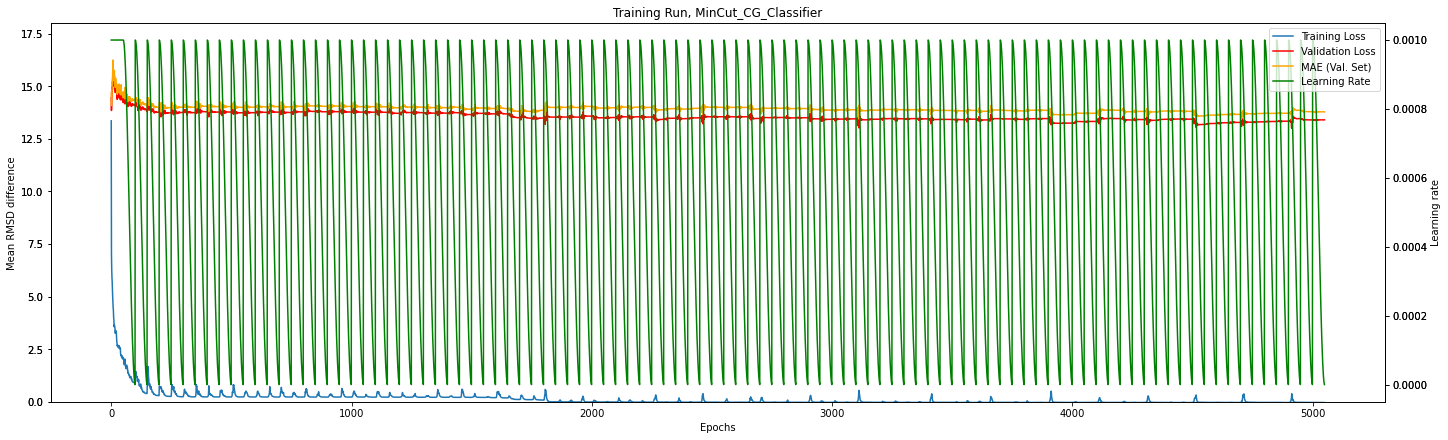

In [2]:
#Training
model = MinCut_CG_Classifier(training_dataset.num_node_features)

parent_dir = "run_data/"


#epoch_losses, val_losses, mae_losses, learning_rates, epoch_add_losses = 
#with th.autograd.detect_anomaly():
pool_train_loop(
    model=model,
    train_dataset=training_dataset,
    val_dataset=val_dataset,
    model_dir=parent_dir,
    device=device,
    b_size=64,
    lr=1e-3,
    epochs=5_000,
    sched_T0=50,
    vectorize=vectorize,
    k=k,
    burn_in=50)

In [3]:
#get training run data

run_dir = "run_data/2022-05-16_15-18_MinCut_CG_Classifier"
burn_in = 50

file_lines = []
with open(run_dir + "/loss_data.txt", "r") as fh:
    for line in fh.readlines():
        file_lines.append(line.rstrip("]\n").lstrip("[").split(","))

epoch_losses = [float(a) for a in file_lines[0]]
val_losses = [float(b) for b in file_lines[1]]
learning_rates = [float(c) for c in file_lines[2]]
mae_losses = [float(d) for d in file_lines[3]]
epoch_add_losses = [float(d) for d in file_lines[4]]

print(f"Minimum Training Loss {min(epoch_losses):.4f} in epoch {epoch_losses.index(min(epoch_losses))}")
print(f"Minimum Validation Loss (after {burn_in} epochs) {min(val_losses[burn_in:]):.4f} in epoch {val_losses.index(min(val_losses[burn_in:]))}")
print(f"Minimum MAE (after {burn_in} epochs) {min(mae_losses[burn_in:]):.4f} in epoch {mae_losses.index(min(mae_losses[burn_in:]))}")


Minimum Training Loss -0.0374 in epoch 4491
Minimum Validation Loss (after 50 epochs) 13.0062 in epoch 4913
Minimum MAE (after 50 epochs) 13.3899 in epoch 4913


In [5]:
print(len(epoch_losses))

7771


Validation Loss at 4913 is 13.0062
5 before select
13.3003, 13.3933, 13.3263, 13.4306, 13.0359
5 after select
13.3052, 13.4755, 13.2774, 13.2633, 13.3856
MAE at 4913 is 13.3899


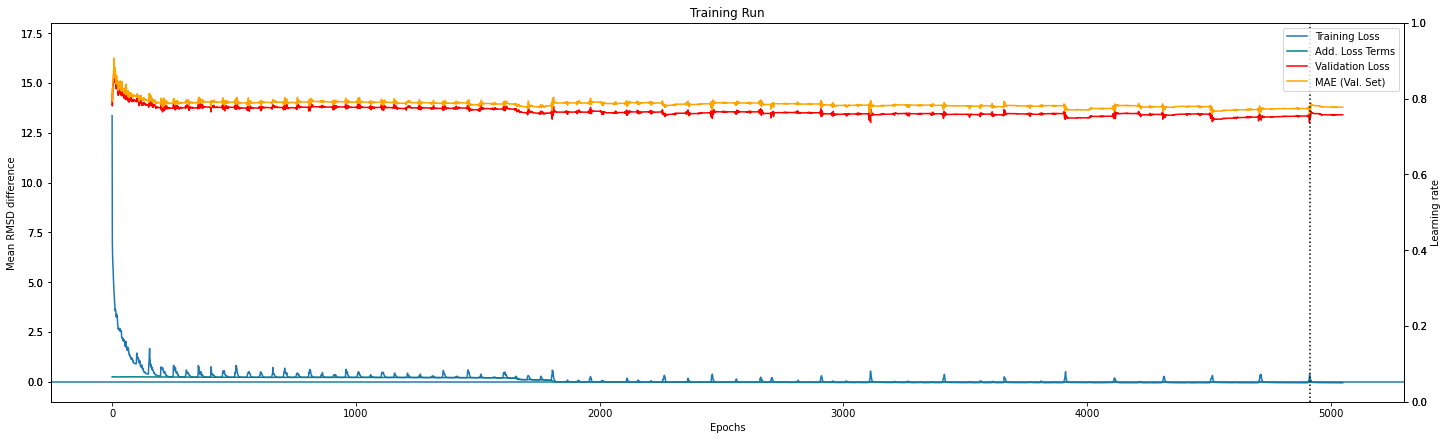

In [8]:
#plot the training run
select = 4913
print(f"Validation Loss at {select} is {val_losses[select]:.4f}")
print("5 before select")
print((", ").join([f"{x:.4f}" for x in val_losses[select-5:select]]))
print("5 after select")
print((", ").join([f"{y:.4f}" for y in val_losses[select+1:select+6]]))
print(f"MAE at {select} is {mae_losses[select]:.4f}")

fig, ax1 = plt.subplots(layout="constrained", figsize=(20, 6))
ax1.secondary_yaxis("left")
ax1.plot(epoch_losses, label="Training Loss")
ax1.plot(epoch_add_losses, "teal", label="Add. Loss Terms")
ax1.plot(val_losses, "r", label="Validation Loss")
ax1.plot(mae_losses, "orange", label="MAE (Val. Set)")
ax2 = ax1.twinx()
ax2.secondary_yaxis("right")
#ax2.plot(learning_rates, "g", label="Learning Rate")
plt.title("Training Run")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Mean RMSD difference")
ax2.set_ylabel("Learning rate")
ax1.set_ybound(lower=-1, upper=max(val_losses)+2)
plt.axvline(x = select, c = "black", ls = ':')
ax1.axhline(y=0)
han1, lab1 = ax1.get_legend_handles_labels()
han2, lab2 = ax2.get_legend_handles_labels()
plt.legend(han1 + han2, lab1 + lab2, loc="upper right")
plt.draw()

Using state dict from epoch 4913
Test Set
Minimum Loss: Label = 26.2560, Prediction = 26.0993, Loss = 0.0123
Maximum Loss: Label = 0.0000, Prediction = 29.5515, Loss = 29.0515
Mean Test loss: 	 12.5537
Std. Dev. of Test loss:  8.3719
Min loss: 		 0.0123
First Quantile: 	 5.4720
Median: 		 12.0113
Third Quantile: 	 20.1396
Max Loss: 		 29.0515
LinregressResult(slope=-1.3779259977242344, intercept=47.164302628224476, rvalue=-0.4163271874810115, pvalue=4.881540285913742e-13, stderr=0.18146434386428972, intercept_stderr=4.056190835007501)


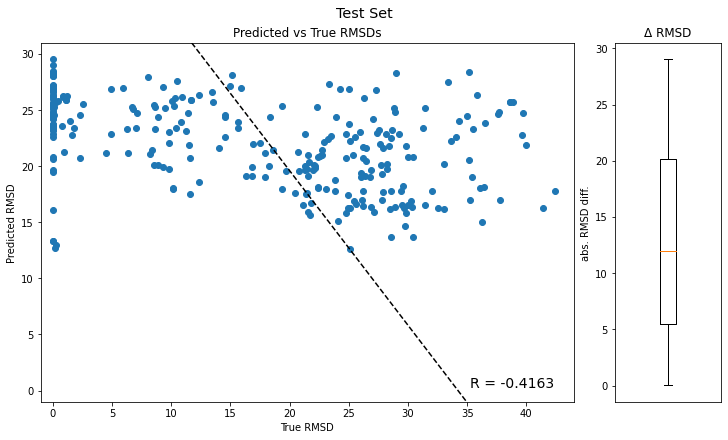

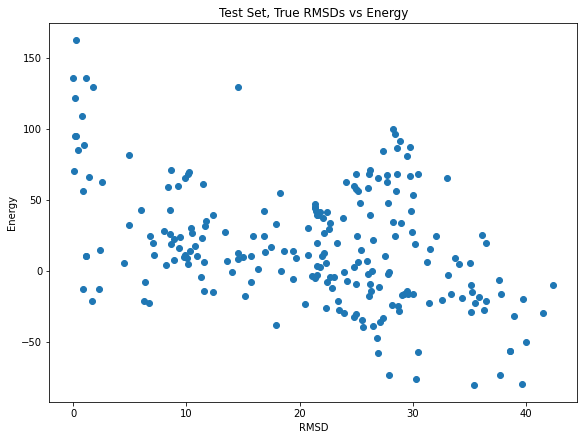

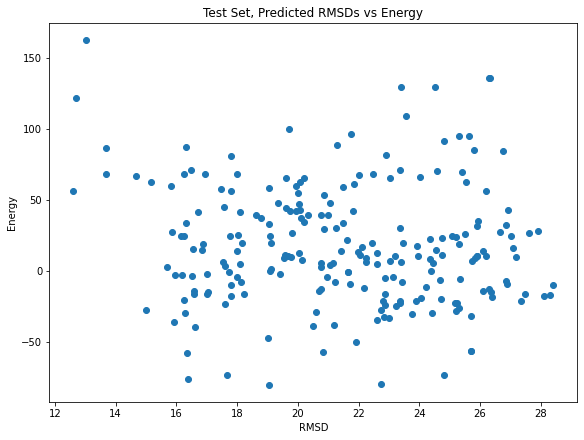

5S and tRNA Test Set
Minimum Loss: Label = 18.6410, Prediction = 18.6415, Loss = 0.0000
Maximum Loss: Label = 0.0000, Prediction = 26.8298, Loss = 26.3298
Mean Test loss: 	 4.0653
Std. Dev. of Test loss:  4.8024
Min loss: 		 0.0000
First Quantile: 	 0.8943
Median: 		 2.3852
Third Quantile: 	 5.4031
Max Loss: 		 26.3298
LinregressResult(slope=0.9081417652061529, intercept=-0.5812084208296309, rvalue=0.7194827846463384, pvalue=2.410914442204153e-173, stderr=0.026662389646923905, intercept_stderr=0.5191334746763722)


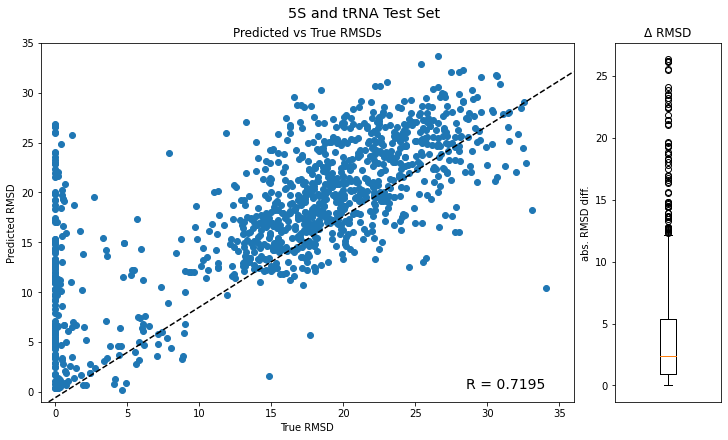

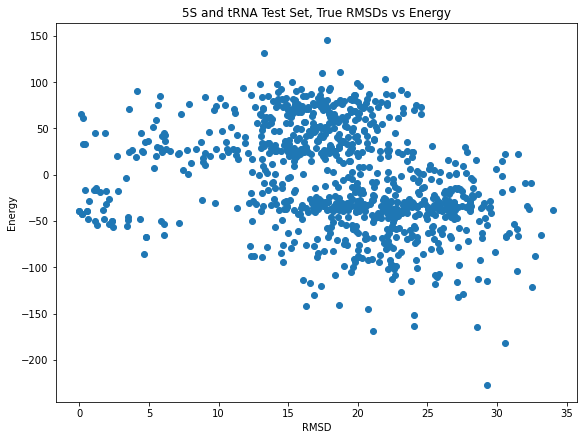

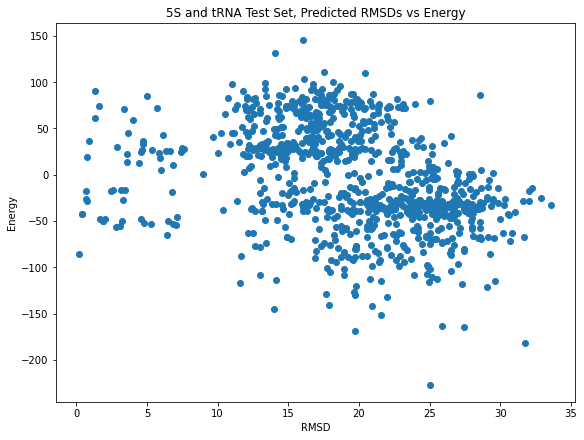

Training Set
Minimum Loss: Label = 27.5750, Prediction = 27.5749, Loss = 0.0000
Maximum Loss: Label = 18.7370, Prediction = 11.4536, Loss = 6.7834
Mean Test loss: 	 0.2617
Std. Dev. of Test loss:  0.4907
Min loss: 		 0.0000
First Quantile: 	 0.0181
Median: 		 0.0797
Third Quantile: 	 0.2601
Max Loss: 		 6.7834
LinregressResult(slope=1.0070901911865597, intercept=-0.28490372938449227, rvalue=0.9961560865035404, pvalue=0.0, stderr=0.0032165508532352085, intercept_stderr=0.06500715163441832)


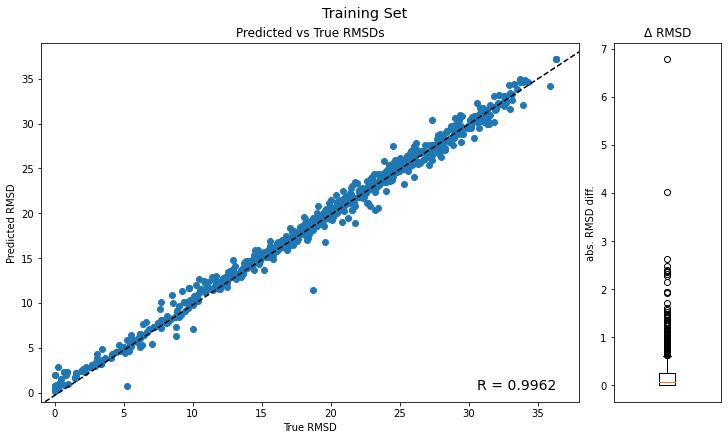

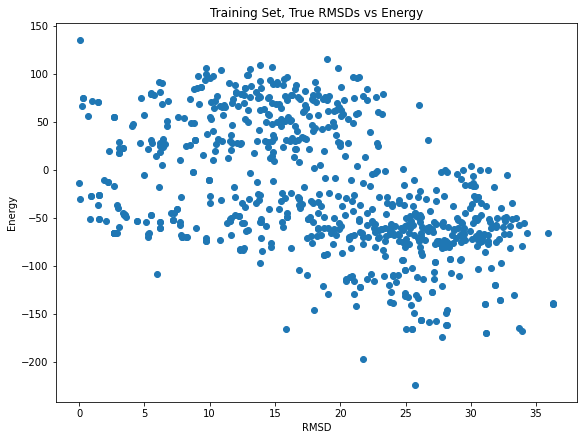

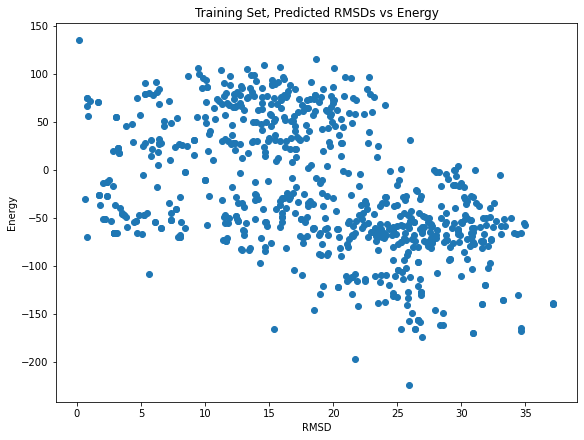

Validation Set
Minimum Loss: Label = 24.4410, Prediction = 24.3870, Loss = 0.0015
Maximum Loss: Label = 61.9850, Prediction = 16.5001, Loss = 44.9849
Mean Test loss: 	 12.8273
Std. Dev. of Test loss:  9.7324
Min loss: 		 0.0015
First Quantile: 	 4.6943
Median: 		 11.6964
Third Quantile: 	 19.7731
Max Loss: 		 44.9849
LinregressResult(slope=0.20724173824793202, intercept=18.67422342612991, rvalue=0.06219097116971158, pvalue=0.21687958670275745, stderr=0.1675561157832833, intercept_stderr=3.782703822135607)


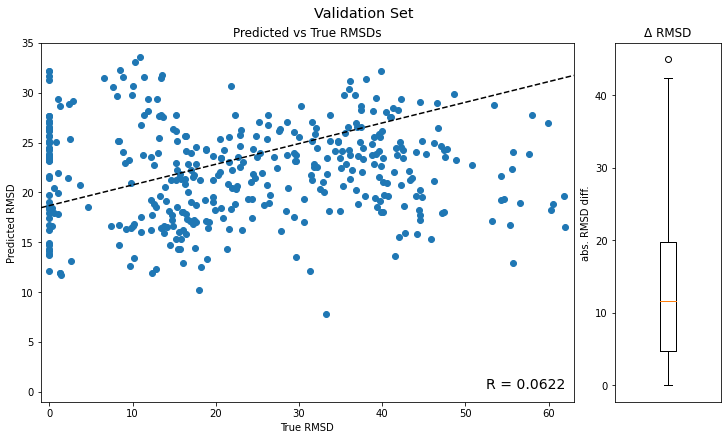

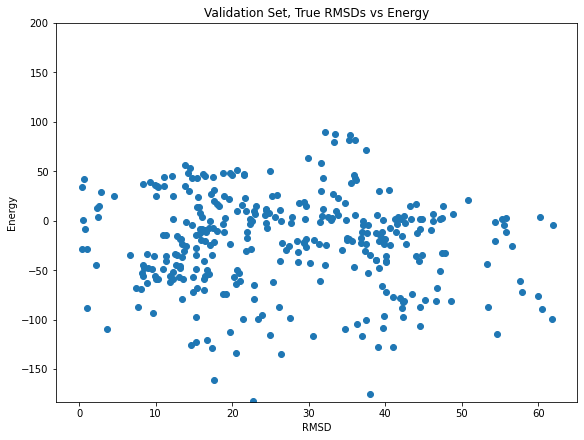

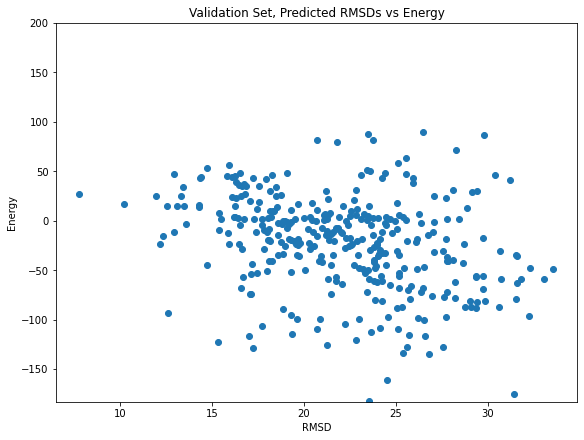

LinregressResult(slope=0.6712740993980656, intercept=7.192251595697783, rvalue=0.38081238550539526, pvalue=1.1883540120841481e-52, stderr=0.042239614317878635, intercept_stderr=0.8910425823610629)


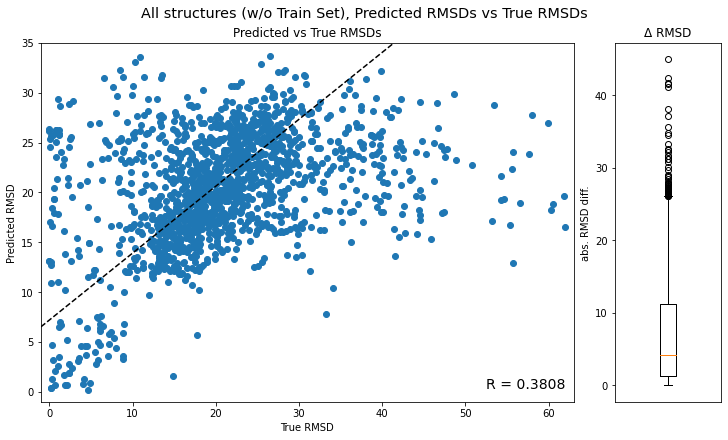

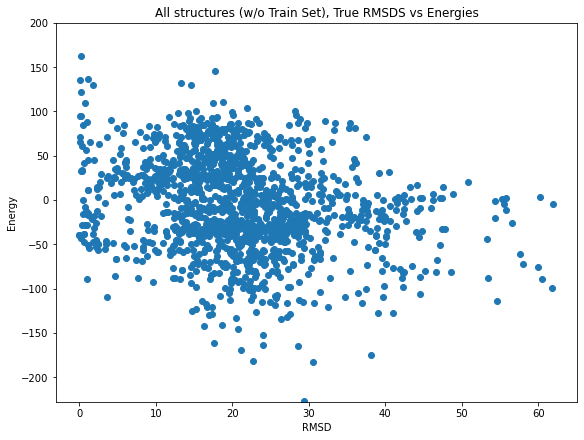

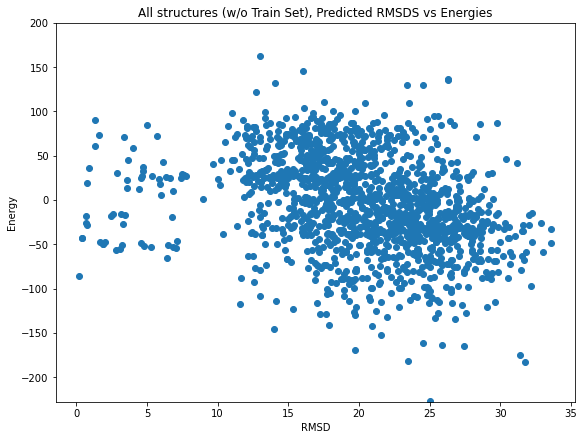

In [7]:
#Test
from classifier.utility import get_energy_dict, rmsd_scatter, e_rmsd_scatter

if "model" not in globals():
    print("Model not in global variables")
    model = MinCut_CG_Classifier(training_dataset.num_node_features).to(device)

train_loader = DataLoader(training_dataset, batch_size=1)
val_loader = DataLoader(val_dataset, batch_size=1)
test_dataloader = DataLoader(test_dataset, batch_size=1)
st_test_dataloader = DataLoader(st_test_dataset, batch_size=1)

model.to(device)
checkpoint = th.load(f"{run_dir}/model_data/epoch_{select}.pth")
print(f"Using state dict from epoch {checkpoint['epoch']}")
model.load_state_dict(checkpoint["model_state_dict"])

energy_l = []
true_rmsd_l = []
pred_rmsd_l = []
test_ls = []
for loader in [test_dataloader, st_test_dataloader, train_loader, val_loader]:
    if loader == test_dataloader:
        title = "Test Set"
        e_dict = get_energy_dict("data/test_energy.txt")
    elif loader == st_test_dataloader:
        title = "5S and tRNA Test Set"
        e_dict = get_energy_dict("data/old_train_energy.txt")
    elif loader == train_loader:
        title = "Training Set"
        e_dict = get_energy_dict("data/train_energy.txt")
    elif loader == val_loader:
        title = "Validation Set"
        e_dict = get_energy_dict("data/val_energy.txt")
    en, trs, prs, tlosses = pool_test_loop(model, loader, e_dict, title, device)
    if loader != train_loader:
        energy_l += en
        true_rmsd_l += trs
        pred_rmsd_l += prs
        test_ls += tlosses

rmsd_scatter(pred_rmsd_l, true_rmsd_l, test_ls, "All structures (w/o Train Set), Predicted RMSDs vs True RMSDs")
e_rmsd_scatter(energy_l, true_rmsd_l, "All structures (w/o Train Set), True RMSDS vs Energies")
e_rmsd_scatter(energy_l, pred_rmsd_l, "All structures (w/o Train Set), Predicted RMSDS vs Energies")

LinregressResult(slope=0.8985976064527387, intercept=1.9730220103674334, rvalue=0.9385922072387576, pvalue=4.162061344601973e-129, stderr=0.01991943158816726, intercept_stderr=0.39865131142785726)


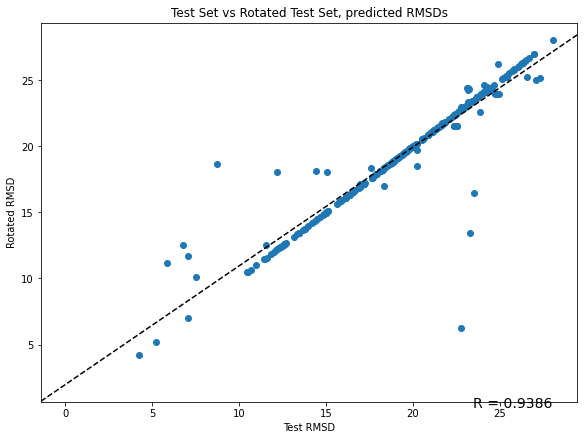

LinregressResult(slope=0.9594322625662947, intercept=0.46740383828043797, rvalue=0.976025676260666, pvalue=3.792671399234506e-184, stderr=0.012901975209829808, intercept_stderr=0.1765015667990376)


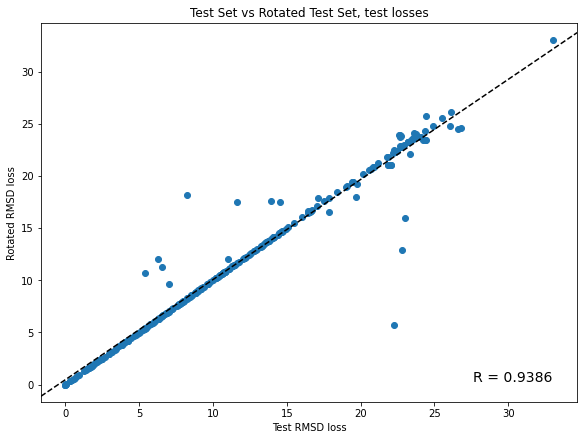

LinregressResult(slope=0.9692862689906069, intercept=0.5753457943968137, rvalue=0.9720414263704595, pvalue=0.0, stderr=0.007121475130449396, intercept_stderr=0.1300284921320054)


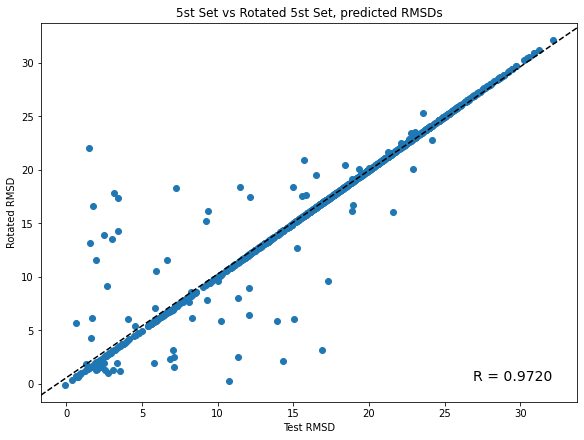

LinregressResult(slope=0.9527686789182161, intercept=0.2368081670666622, rvalue=0.9217776291182489, pvalue=0.0, stderr=0.012188928100707812, intercept_stderr=0.06857629145634152)


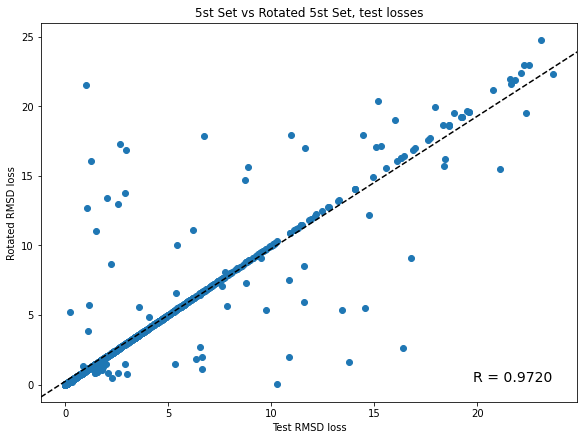

In [8]:
#Test run for rotational invariance
from scipy.stats import linregress
rot_test_dataloader = DataLoader(rot_test_dataset, batch_size=1)
fst_rot_dataloader = DataLoader(fst_rot_dataset, batch_size=1)

def rot_eval(dataloader, rot_dataloader):
    pred_dir = {}
    loss_dir = {}
    for loader in [dataloader, rot_dataloader]:
        with th.no_grad():
            model.eval()
            for test_graph in loader:
                test_graph = test_graph.to(device)
                test_pred, _ = model(test_graph)
                test_loss = F.smooth_l1_loss(test_pred, test_graph.y).item()

                if test_graph.name[0] not in pred_dir.keys():
                    pred_dir[test_graph.name[0]] = [float(test_pred)]
                else:
                    pred_dir[test_graph.name[0]].append(float(test_pred))
                
                if test_graph.name[0] not in loss_dir.keys():
                    loss_dir[test_graph.name[0]] = [float(test_loss)]
                else:
                    loss_dir[test_graph.name[0]].append(float(test_loss))
    return pred_dir, loss_dir

def rot_plot(pred_dir, loss_dir, title):
    test_preds = []
    trot_preds = []
    for a in pred_dir.keys():
        test_preds.append(pred_dir[a][0])
        trot_preds.append(pred_dir[a][1])

    test_ls = []
    trot_ls = []
    for b in loss_dir.keys():
        test_ls.append(loss_dir[b][0])
        trot_ls.append(loss_dir[b][1])

    reg = linregress(test_preds, trot_preds)
    print(reg)

    fig1, axs1 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", predicted RMSDs")
    axs1.scatter(test_preds, trot_preds)
    axs1.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="k")
    axs1.text(max(test_preds), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD")
    plt.ylabel("Rotated RMSD")
    plt.show()

    reg_l = linregress(test_ls, trot_ls)
    print(reg_l)

    fig2, axs2 = plt.subplots(layout='constrained', figsize=(8, 6))
    plt.title(title + ", test losses")
    axs2.scatter(test_ls, trot_ls)
    axs2.axline(xy1=(0, reg_l.intercept), slope=reg_l.slope, linestyle="--", color="k")
    axs2.text(max(test_ls), 0.01, f"R = {reg.rvalue:.4f}", fontsize=14, verticalalignment="bottom", horizontalalignment="right")
    plt.xlabel("Test RMSD loss")
    plt.ylabel("Rotated RMSD loss")
    plt.show()

test_pred_dir, test_loss_dir = rot_eval(test_dataloader, rot_test_dataloader)
rot_plot(test_pred_dir, test_loss_dir, "Test Set vs Rotated Test Set")

fst_pred_dir, fst_loss_dir = rot_eval(st_test_dataloader, fst_rot_dataloader)
rot_plot(fst_pred_dir, fst_loss_dir, "5st Set vs Rotated 5st Set")